## 範例重點

* 知道如何設定監控目標
* 學習如何在 Keras 中加入 Model Checkpoint
* 比較使用最佳與非最佳參數時的表現

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import backend
from keras.utils import np_utils
from keras.datasets import cifar10
from keras.models import Model, load_model
from keras.layers import Input, Dense, BatchNormalization
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint
tf.logging.set_verbosity(tf.logging.ERROR)

Using TensorFlow backend.


## 準備資料

In [2]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [3]:
def normalize_cifar10_data(x, y):
    x = x.reshape((len(x), -1)) / 255.
    y = np_utils.to_categorical(y, num_classes=10)
    return x, y

def normalize_result(x, y):
    print('x.shape:', x.shape)
    print('y.shape:', y.shape)

In [4]:
print('Before normalization:')
normalize_result(X_train, y_train)

Before normalization:
x.shape: (50000, 32, 32, 3)
y.shape: (50000, 1)


In [5]:
print('After normalization:')
X_train, y_train = normalize_cifar10_data(X_train, y_train)
X_test, y_test = normalize_cifar10_data(X_test, y_test)
normalize_result(X_train, y_train)

After normalization:
x.shape: (50000, 3072)
y.shape: (50000, 10)


## 定義函數

In [6]:
default_check_point_param = {'save_best_only': False, 'save_weights_only': False}

class Trainer:
    SAVED_TYPE_MODEL = 'model'
    SAVED_TYPE_WEIGHTS = 'weights'

    def __init__(self, X_train, y_train, X_test, y_test, check_point_path, check_point_param, neuron_numbers=(512, 256, 128,),
                 epochs=50, batch_size=1024, momentum=0.95, learning_rate=1e-3):
        self.X_test = X_test
        self.y_test = y_test
        self.X_train = X_train
        self.y_train = y_train
        self.epochs = epochs
        self.batch_size = batch_size
        self.momentum = momentum
        self.learning_rate = learning_rate
        self.neuron_numbers = neuron_numbers
        self.check_point_path = check_point_path
        self.check_point_param = check_point_param
        self._model = None
        self._score = None
        self._history = None

    @property
    def optimizer(self):
        return SGD(lr=self.learning_rate, momentum=self.momentum, nesterov=True)

    @property
    def callbacks(self):
        return [ModelCheckpoint(self.check_point_path, **self.check_point_param)]

    @property
    def validation_data(self):
        return (self.X_test, self.y_test,)

    def run(self):
        return self._clear()._build()._launch()

    def reload(self, saved_type=SAVED_TYPE_MODEL):
        self._clear()
        if saved_type == self.SAVED_TYPE_MODEL:
            self._model = load_model(self.check_point_path)
        else:
            self._build()._model.load_weights(self.check_point_path)
        return self

    def _clear(self):
        backend.clear_session()
        self._model = None
        return self

    def _build(self):
        main_input = hidden_input = Input(shape=self.X_train.shape[-1:], name='main_input')
        for i, neuron_number in enumerate(self.neuron_numbers):
            hidden_input = Dense(units=neuron_number, activation='relu', name=f'hidden_layer{i}')(hidden_input)
            hidden_input = BatchNormalization()(hidden_input)
        main_output = Dense(units=self.y_train.shape[-1], activation='softmax', name='main_output')(hidden_input)
        self._model = Model(inputs=[main_input], outputs=[main_output])
        self._model.compile(optimizer=self.optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
        return self

    def _launch(self):
        print('Experiment with check point param: {}'.format(self.check_point_param))
        self._model.summary()
        self._history = self._model.fit(
            self.X_train, self.y_train, epochs=self.epochs, batch_size=self.batch_size,
            validation_data=self.validation_data, callbacks=self.callbacks, shuffle=True, verbose=2)
        return self

    def evaluate(self):
        self._score = dict(zip(('val_loss', 'val_acc',), self._model.evaluate(self.X_test, self.y_test)))
        return self

    def display(self, train_name, val_name):
        plt.figure(figsize=(8, 6,))
        plt.plot(self._history.history[train_name])
        plt.plot(self._history.history[val_name])
        plt.hlines(self._score[val_name], xmin=0, xmax=self.epochs, colors='r', linestyles='--')
        plt.xlabel('Epoch')
        plt.ylabel(train_name)
        plt.title('Train History')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.show()

## 訓練模型

In [7]:
# 設定超參數
check_point_path = 'data/part07/day_086_cifar10_model.h5'
check_point_param = {**default_check_point_param, 'save_best_only': True}

In [8]:
trainer = Trainer(X_train, y_train, X_test, y_test, check_point_path, check_point_param).run()

Experiment with check point param: {'save_best_only': True, 'save_weights_only': False}
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 3072)              0         
_________________________________________________________________
hidden_layer0 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 128)               32896     
______________________________________________________

In [9]:
trainer = trainer.reload().evaluate()

10000/10000 [==============================] - 1s 118us/step


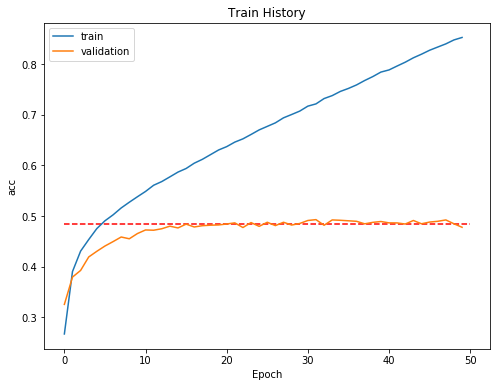

In [10]:
trainer.display('acc', 'val_acc')

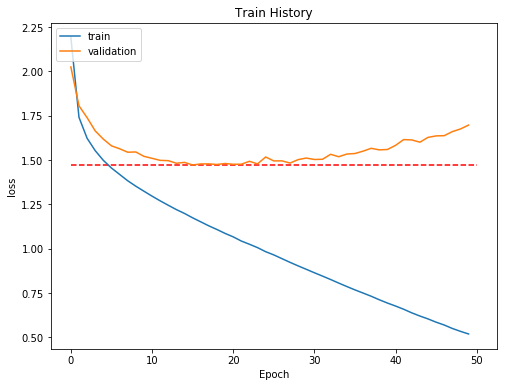

In [11]:
trainer.display('loss', 'val_loss')

## 作業

1. 試比較 save_best_only = False 的差異，並嘗試重載模型預測表現
2. 試比較 save_weights_only = True 的差異，並嘗試重載模型預測表現